## Gradient boost with xgboost API
### Author: Zhi Li
### Date: 04232019

In [1]:
import os, fnmatch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
import xgboost as xgb
import optunity
import optunity.metrics

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# Function to compute ROC curve and ROC area for each class
def roc (y_test, y_score, name):
    fpr = []
    tpr = []
    thresholds = []
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc=auc(fpr,tpr)

    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.savefig(name,dpi = 1000)
    plt.legend(loc="lower right")
    plt.show()

In [6]:
# Utility function to move the midpoint of a colormap to be around the values of interest.
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0.2, 0.6, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [7]:
# Data input
file = "PostRunFulldataset_RRP_random only.csv"
Perovskite = "All amines"
df=pd.read_csv(file)
df = df.rename(index=str, columns={"_rxn_organic-inchikey": "_rxn_organic_inchikey"})
df = df[(df._rxn_organic_inchikey != "UUDRLGYROXTISK-UHFFFAOYSA-N")] # remove G2PbI4 since it is ONLY PbI2

In [8]:
X = df.drop(['RunID_vial', '_out_crystalscore', '_rxn_organic_inchikey'], axis =1)
y = df.filter(['_out_crystalscore'], axis =1)

# Standarize the input
x = StandardScaler().fit_transform(X) # dataframe turned into array and it is reformed as dataframe in the below line
X = pd.DataFrame(x, index = X.index, columns = X.columns)
y = (y.replace([1,2,3],0)).replace(4,1) # turned into binary classification

In [9]:
# crossvalidation options
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#T_T split for test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [24]:
clf_xgboost = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
clf_xgboost.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
y_score = clf_xgboost.predict_proba(X_test)
y_predict = clf_xgboost.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metric Report
             precision    recall  f1-score   support

          0       0.82      0.93      0.87       221
          1       0.73      0.49      0.59        88

avg / total       0.79      0.80      0.79       309

Test accuracy is 0.8025889967637541


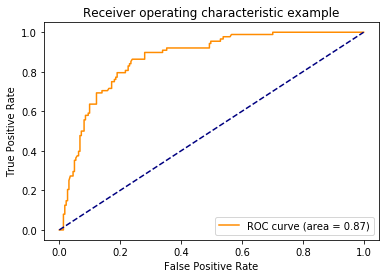

In [27]:
print("Metric Report")
print(classification_report(y_test,y_predict))
print("Test accuracy is", clf_xgboost.score(X_test, y_test))
# Compute ROC curve and ROC area for each class
roc(y_test,y_score[:, 1],'_xgboost_ROC.png')